In [1]:
import pandas as pd
import numpy as np
import censusdata
import geopandas as gpd
import geoplot as gplt
from matplotlib.patches import Polygon
from shapely.ops import nearest_points
import requests
import json

import matplotlib.pyplot as plt
%matplotlib inline

# Crimes

Things to do:
- Incorporate N/S/E/W (see Eric's example)
- Neighborhoods
- Clean out outliers - the crimes per capita is off!
- Convert things to API

In [2]:
# API: https://data.cityofchicago.org/resource/ijzp-q8t2.json
# source: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data
# crimes = pd.read_csv("../data/chicago-crimes-2019.csv")
crimes = pd.read_csv("data/Crimes-2013-2019.csv")
crimes.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11994465,JD167343,08/26/2013 12:01:00 AM,062XX S ST LOUIS AVE,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,False,True,...,23.0,66.0,02,NaN,NaN,2013,05/22/2020 03:46:29 PM,NaN,NaN,NaN
1,9137935,HW283197,05/18/2013 04:00:00 AM,034XX N CICERO AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,31.0,15.0,02,NaN,NaN,2013,05/21/2020 03:47:16 PM,NaN,NaN,NaN
2,12053700,JD236020,03/26/2013 12:01:00 AM,014XX N CLAREMONT AVE,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,MEDICAL / DENTAL OFFICE,False,False,...,1.0,24.0,02,NaN,NaN,2013,05/19/2020 03:51:22 PM,NaN,NaN,NaN
3,9439554,HW583930,12/25/2013 10:24:00 PM,073XX S GREENWOOD AVE,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,True,False,...,5.0,69.0,03,1184825.0,1856507.0,2013,05/18/2020 03:45:11 PM,41.761413,-87.598159,"(41.7614134, -87.59815938)"
4,11863840,JC475022,10/16/2013 08:13:00 PM,017XX W 21ST ST,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,False,...,25.0,31.0,17,NaN,NaN,2013,05/16/2020 03:46:46 PM,NaN,NaN,NaN


### Overview of data sources:
- ACS: American Community Survey: total population by block
- Census: provides census block boundaries (multi-polygon)
- Crime: crime with location (lat/long)

In [3]:
crime_gdf = gpd.GeoDataFrame(
    crimes, geometry=gpd.points_from_xy(crimes.Longitude, crimes.Latitude))

census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")

In [4]:
years = [2013, 2014, 2015, 2016, 2017, 2018]
tables = ['B02001_001E']

def gather_census(years, tables):
    df = pd.DataFrame()
    for t in tables:
        table = pd.DataFrame()
        for y in years:
            temp = pd.DataFrame(censusdata.download(
                 "acs5", y, censusdata.censusgeo(
                 [("state", "17"), ("county", "031"), ("block group", "*")]),
                 [t, "GEO_ID"])).reset_index(drop=True)
            temp['Year'] = y
            table = table.append(temp)
            
        if df.shape[0] == 0:
            df = table
        else:
            df = pd.merge(df, table, how="inner", on=["GEO_ID", "Year"])
            
    return df

In [5]:
acs_df = gather_census(years, tables)
acs_df = acs_df.rename(columns={"B02001_001E": "total_pop"})
acs_df

,total_pop,GEO_ID,Year
0,1064,1500000US170310302003,2013
1,1828,1500000US170310302004,2013
2,1306,1500000US170310303001,2013
3,1625,1500000US170310303002,2013
4,1450,1500000US170310304001,2013
...,...,...,...
3988,1393,1500000US170312909004,2018
3989,926,1500000US170318288014,2018
3990,679,1500000US170315103003,2018
3991,1591,1500000US170316304002,2018


In [6]:
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
acs_df["geo_12"] = acs_df["GEO_ID"].map(lambda x: str(x)[-12:])

In [7]:
census_gdf

,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10,geometry,geo_12
0,17,Block 2010,2010,6903002010,170316903002010,690300,031,"MULTIPOLYGON (((-87.62907 41.76909, -87.62905 ...",170316903002
1,17,Block 3007,3007,6809003007,170316809003007,680900,031,"MULTIPOLYGON (((-87.63412 41.77447, -87.63410 ...",170316809003
2,17,Block 3013,3013,6809003013,170316809003013,680900,031,"MULTIPOLYGON (((-87.63485 41.77263, -87.63522 ...",170316809003
3,17,Block 4019,4019,2909004019,170312909004019,290900,031,"MULTIPOLYGON (((-87.73841 41.85913, -87.73842 ...",170312909004
4,17,Block 4016,4016,2925004016,170312925004016,292500,031,"MULTIPOLYGON (((-87.73217 41.85476, -87.73226 ...",170312925004
...,...,...,...,...,...,...,...,...,...
46352,17,Block 1028,1028,2203001028,170312203001028,220300,031,"MULTIPOLYGON (((-87.69323 41.92767, -87.69385 ...",170312203001
46353,17,Block 1030,1030,2203001030,170312203001030,220300,031,"MULTIPOLYGON (((-87.69320 41.92667, -87.69351 ...",170312203001
46354,17,Block 2014,2014,8310002014,170318310002014,831000,031,"MULTIPOLYGON (((-87.67759 41.91624, -87.67759 ...",170318310002
46355,17,Block 2001,2001,8310002001,170318310002001,831000,031,"MULTIPOLYGON (((-87.67398 41.91783, -87.67397 ...",170318310002


In [8]:
#merged census block geometries and total population per block
merged_gdf = acs_df.merge(census_gdf, on="geo_12", how="inner")
merged_gdf = gpd.GeoDataFrame(merged_gdf)
merged_gdf

,total_pop,GEO_ID,Year,geo_12,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10,geometry
0,1064,1500000US170310302003,2013,170310302003,17,Block 3010,3010,0302003010,170310302003010,030200,031,"MULTIPOLYGON (((-87.66764 41.99218, -87.66764 ..."
1,1064,1500000US170310302003,2013,170310302003,17,Block 3004,3004,0302003004,170310302003004,030200,031,"MULTIPOLYGON (((-87.66525 41.99357, -87.66525 ..."
2,1064,1500000US170310302003,2013,170310302003,17,Block 3012,3012,0302003012,170310302003012,030200,031,"MULTIPOLYGON (((-87.66520 41.99176, -87.66519 ..."
3,1064,1500000US170310302003,2013,170310302003,17,Block 3000,3000,0302003000,170310302003000,030200,031,"MULTIPOLYGON (((-87.66528 41.99450, -87.66528 ..."
4,1064,1500000US170310302003,2013,170310302003,17,Block 3014,3014,0302003014,170310302003014,030200,031,"MULTIPOLYGON (((-87.66940 41.99081, -87.66954 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
278137,0,1500000US170319801001,2018,170319801001,17,Block 1002,1002,9801001002,170319801001002,980100,031,"MULTIPOLYGON (((-87.73894 41.79108, -87.73893 ..."
278138,0,1500000US170319801001,2018,170319801001,17,Block 1008,1008,9801001008,170319801001008,980100,031,"MULTIPOLYGON (((-87.74174 41.78770, -87.74165 ..."
278139,0,1500000US170319801001,2018,170319801001,17,Block 1005,1005,9801001005,170319801001005,980100,031,"MULTIPOLYGON (((-87.75442 41.77819, -87.75516 ..."
278140,0,1500000US170319801001,2018,170319801001,17,Block 1004,1004,9801001004,170319801001004,980100,031,"MULTIPOLYGON (((-87.74162 41.79304, -87.74162 ..."


In [9]:
#merged the acs-census data with crime data
allmerged_gdf = gpd.sjoin(crime_gdf, merged_gdf, how='left')
allmerged_gdf

/Users/ezhang/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,GEO_ID,Year_right,geo_12,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10
0,11994465,JD167343,08/26/2013 12:01:00 AM,062XX S ST LOUIS AVE,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9137935,HW283197,05/18/2013 04:00:00 AM,034XX N CICERO AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12053700,JD236020,03/26/2013 12:01:00 AM,014XX N CLAREMONT AVE,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,MEDICAL / DENTAL OFFICE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9439554,HW583930,12/25/2013 10:24:00 PM,073XX S GREENWOOD AVE,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,True,False,...,1500000US170318418001,2013.0,170318418001,17,Block 1003,1003,8418001003,170318418001003,841800,031
3,9439554,HW583930,12/25/2013 10:24:00 PM,073XX S GREENWOOD AVE,0326,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,True,False,...,1500000US170318418001,2014.0,170318418001,17,Block 1003,1003,8418001003,170318418001003,841800,031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912153,24558,JC278685,05/25/2019 11:43:00 PM,004XX W 77TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1500000US170316912001,2014.0,170316912001,17,Block 1016,1016,6912001016,170316912001016,691200,031
1912153,24558,JC278685,05/25/2019 11:43:00 PM,004XX W 77TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1500000US170316912001,2015.0,170316912001,17,Block 1016,1016,6912001016,170316912001016,691200,031
1912153,24558,JC278685,05/25/2019 11:43:00 PM,004XX W 77TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1500000US170316912001,2016.0,170316912001,17,Block 1016,1016,6912001016,170316912001016,691200,031
1912153,24558,JC278685,05/25/2019 11:43:00 PM,004XX W 77TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1500000US170316912001,2017.0,170316912001,17,Block 1016,1016,6912001016,170316912001016,691200,031


In [10]:
#keeping only necessary columns
limited_gdf = allmerged_gdf[["total_pop", "ID", "Case Number", "Year_left", "Primary Type", "blockce10", "GEO_ID", "geometry"]]
limited_gdf

,total_pop,ID,Case Number,Year_left,Primary Type,blockce10,GEO_ID,geometry
0,NaN,11994465,JD167343,2013,CRIMINAL SEXUAL ASSAULT,NaN,NaN,POINT (nan nan)
1,NaN,9137935,HW283197,2013,CRIMINAL SEXUAL ASSAULT,NaN,NaN,POINT (nan nan)
2,NaN,12053700,JD236020,2013,CRIMINAL SEXUAL ASSAULT,NaN,NaN,POINT (nan nan)
3,481.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.598 41.761)
3,609.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.598 41.761)
...,...,...,...,...,...,...,...,...
1912153,1275.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.635 41.754)
1912153,1342.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.635 41.754)
1912153,1701.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.635 41.754)
1912153,1461.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.635 41.754)


In [11]:
limited_gdf = limited_gdf[limited_gdf.total_pop != 0]
limited_gdf = limited_gdf.dropna()
limited_gdf

,total_pop,ID,Case Number,Year_left,Primary Type,blockce10,GEO_ID,geometry
3,481.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.59816 41.76141)
3,609.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.59816 41.76141)
3,623.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.59816 41.76141)
3,713.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.59816 41.76141)
3,909.0,9439554,HW583930,2013,ROBBERY,1003,1500000US170318418001,POINT (-87.59816 41.76141)
...,...,...,...,...,...,...,...,...
1912153,1275.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.63479 41.75442)
1912153,1342.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.63479 41.75442)
1912153,1701.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.63479 41.75442)
1912153,1461.0,24558,JC278685,2019,HOMICIDE,1016,1500000US170316912001,POINT (-87.63479 41.75442)


### Calculating crime per capita for each block

In [12]:
count_by_block = pd.Series(limited_gdf.groupby(['GEO_ID', 'Year_left'])['Case Number'].count(), name='crime_count')
count_by_block = count_by_block.to_frame()
count_by_block

crime_count
GEO_ID                Year_left             
1500000US170310101001 2013               486
                      2014               456
                      2015               546
                      2016               366
                      2017               474
...                                      ...
1500000US170318439005 2015               366
                      2016               384
                      2017               300
                      2018               570
                      2019               642

[15234 rows x 1 columns]

In [13]:
pop_by_geo = pd.Series(limited_gdf.groupby(['GEO_ID', 'Year_left'])['total_pop'].sum(), name='total_pop').reset_index()
pop_by_geo

,GEO_ID,Year_left,total_pop
0,1500000US170310101001,2013,251586.0
1,1500000US170310101001,2014,236056.0
2,1500000US170310101001,2015,282646.0
3,1500000US170310101001,2016,189466.0
4,1500000US170310101001,2017,245374.0
...,...,...,...
15229,1500000US170318439005,2015,267485.0
15230,1500000US170318439005,2016,280640.0
15231,1500000US170318439005,2017,219250.0
15232,1500000US170318439005,2018,416575.0


In [14]:
crimes_and_pop = count_by_block.merge(pop_by_geo, on=["GEO_ID","Year_left"], how="inner").reset_index()
crimes_and_pop

,index,GEO_ID,Year_left,crime_count,total_pop
0,0,1500000US170310101001,2013,486,251586.0
1,1,1500000US170310101001,2014,456,236056.0
2,2,1500000US170310101001,2015,546,282646.0
3,3,1500000US170310101001,2016,366,189466.0
4,4,1500000US170310101001,2017,474,245374.0
...,...,...,...,...,...
15229,15229,1500000US170318439005,2015,366,267485.0
15230,15230,1500000US170318439005,2016,384,280640.0
15231,15231,1500000US170318439005,2017,300,219250.0
15232,15232,1500000US170318439005,2018,570,416575.0


In [15]:
joined2=crimes_and_pop
joined2

,index,GEO_ID,Year_left,crime_count,total_pop
0,0,1500000US170310101001,2013,486,251586.0
1,1,1500000US170310101001,2014,456,236056.0
2,2,1500000US170310101001,2015,546,282646.0
3,3,1500000US170310101001,2016,366,189466.0
4,4,1500000US170310101001,2017,474,245374.0
...,...,...,...,...,...
15229,15229,1500000US170318439005,2015,366,267485.0
15230,15230,1500000US170318439005,2016,384,280640.0
15231,15231,1500000US170318439005,2017,300,219250.0
15232,15232,1500000US170318439005,2018,570,416575.0


### Cleaning up data

In [16]:
# removing rows where population is 0
joined2 = joined2[joined2.total_pop != 0]
joined2.dropna()
joined2.reset_index()
joined2

,index,GEO_ID,Year_left,crime_count,total_pop
0,0,1500000US170310101001,2013,486,251586.0
1,1,1500000US170310101001,2014,456,236056.0
2,2,1500000US170310101001,2015,546,282646.0
3,3,1500000US170310101001,2016,366,189466.0
4,4,1500000US170310101001,2017,474,245374.0
...,...,...,...,...,...
15229,15229,1500000US170318439005,2015,366,267485.0
15230,15230,1500000US170318439005,2016,384,280640.0
15231,15231,1500000US170318439005,2017,300,219250.0
15232,15232,1500000US170318439005,2018,570,416575.0


In [17]:
joined2['crimes_per_capita'] = joined2['crime_count']/joined2['total_pop']

In [18]:
final_gdf = gpd.GeoDataFrame(joined2)
final_gdf

,index,GEO_ID,Year_left,crime_count,total_pop,crimes_per_capita
0,0,1500000US170310101001,2013,486,251586.0,0.001932
1,1,1500000US170310101001,2014,456,236056.0,0.001932
2,2,1500000US170310101001,2015,546,282646.0,0.001932
3,3,1500000US170310101001,2016,366,189466.0,0.001932
4,4,1500000US170310101001,2017,474,245374.0,0.001932
...,...,...,...,...,...,...
15229,15229,1500000US170318439005,2015,366,267485.0,0.001368
15230,15230,1500000US170318439005,2016,384,280640.0,0.001368
15231,15231,1500000US170318439005,2017,300,219250.0,0.001368
15232,15232,1500000US170318439005,2018,570,416575.0,0.001368


### Graphing crimes

In [19]:
crime_graph = final_gdf.groupby('GEO_ID').sum().reset_index()
crime_graph = crime_graph[['GEO_ID', 'crime_count', 'total_pop']]
crime_graph['crimes_per_capita'] = crime_graph['crime_count']/crime_graph['total_pop']
crime_graph

,GEO_ID,crime_count,total_pop,crimes_per_capita
0,1500000US170310101001,3060,1584060.0,0.001932
1,1500000US170310101002,13746,26603092.0,0.000517
2,1500000US170310101003,7308,14614782.0,0.000500
3,1500000US170310102011,3312,5270496.0,0.000628
4,1500000US170310102012,12366,56224080.0,0.000220
...,...,...,...,...
2174,1500000US170318439001,14130,11866845.0,0.001191
2175,1500000US170318439002,4512,1853680.0,0.002434
2176,1500000US170318439003,888,787656.0,0.001127
2177,1500000US170318439004,2790,1859535.0,0.001500


In [20]:
merged_gdf[['GEO_ID', 'geometry']]

,GEO_ID,geometry
0,1500000US170310302003,"MULTIPOLYGON (((-87.66764 41.99218, -87.66764 ..."
1,1500000US170310302003,"MULTIPOLYGON (((-87.66525 41.99357, -87.66525 ..."
2,1500000US170310302003,"MULTIPOLYGON (((-87.66520 41.99176, -87.66519 ..."
3,1500000US170310302003,"MULTIPOLYGON (((-87.66528 41.99450, -87.66528 ..."
4,1500000US170310302003,"MULTIPOLYGON (((-87.66940 41.99081, -87.66954 ..."
...,...,...
278137,1500000US170319801001,"MULTIPOLYGON (((-87.73894 41.79108, -87.73893 ..."
278138,1500000US170319801001,"MULTIPOLYGON (((-87.74174 41.78770, -87.74165 ..."
278139,1500000US170319801001,"MULTIPOLYGON (((-87.75442 41.77819, -87.75516 ..."
278140,1500000US170319801001,"MULTIPOLYGON (((-87.74162 41.79304, -87.74162 ..."


In [21]:
crime_graph2 = crime_graph.merge(merged_gdf[['GEO_ID', 'geometry']], on='GEO_ID')
crime_graph2 = gpd.GeoDataFrame(crime_graph2)
crime_graph2['log_crime_rate'] = np.log(crime_graph2['crimes_per_capita'])
crime_graph2

,GEO_ID,crime_count,total_pop,crimes_per_capita,geometry,log_crime_rate
0,1500000US170310101001,3060,1584060.0,0.001932,"MULTIPOLYGON (((-87.66635 42.02252, -87.66666 ...",-6.249332
1,1500000US170310101001,3060,1584060.0,0.001932,"MULTIPOLYGON (((-87.67009 42.02115, -87.67047 ...",-6.249332
2,1500000US170310101001,3060,1584060.0,0.001932,"MULTIPOLYGON (((-87.67009 42.02226, -87.66994 ...",-6.249332
3,1500000US170310101001,3060,1584060.0,0.001932,"MULTIPOLYGON (((-87.66754 42.02224, -87.66763 ...",-6.249332
4,1500000US170310101001,3060,1584060.0,0.001932,"MULTIPOLYGON (((-87.66635 42.02252, -87.66666 ...",-6.249332
...,...,...,...,...,...,...
277321,1500000US170318439005,3372,2464370.0,0.001368,"MULTIPOLYGON (((-87.57160 41.77319, -87.57162 ...",-6.594185
277322,1500000US170318439005,3372,2464370.0,0.001368,"MULTIPOLYGON (((-87.56997 41.77307, -87.56997 ...",-6.594185
277323,1500000US170318439005,3372,2464370.0,0.001368,"MULTIPOLYGON (((-87.56993 41.77170, -87.56994 ...",-6.594185
277324,1500000US170318439005,3372,2464370.0,0.001368,"MULTIPOLYGON (((-87.57156 41.77168, -87.57157 ...",-6.594185


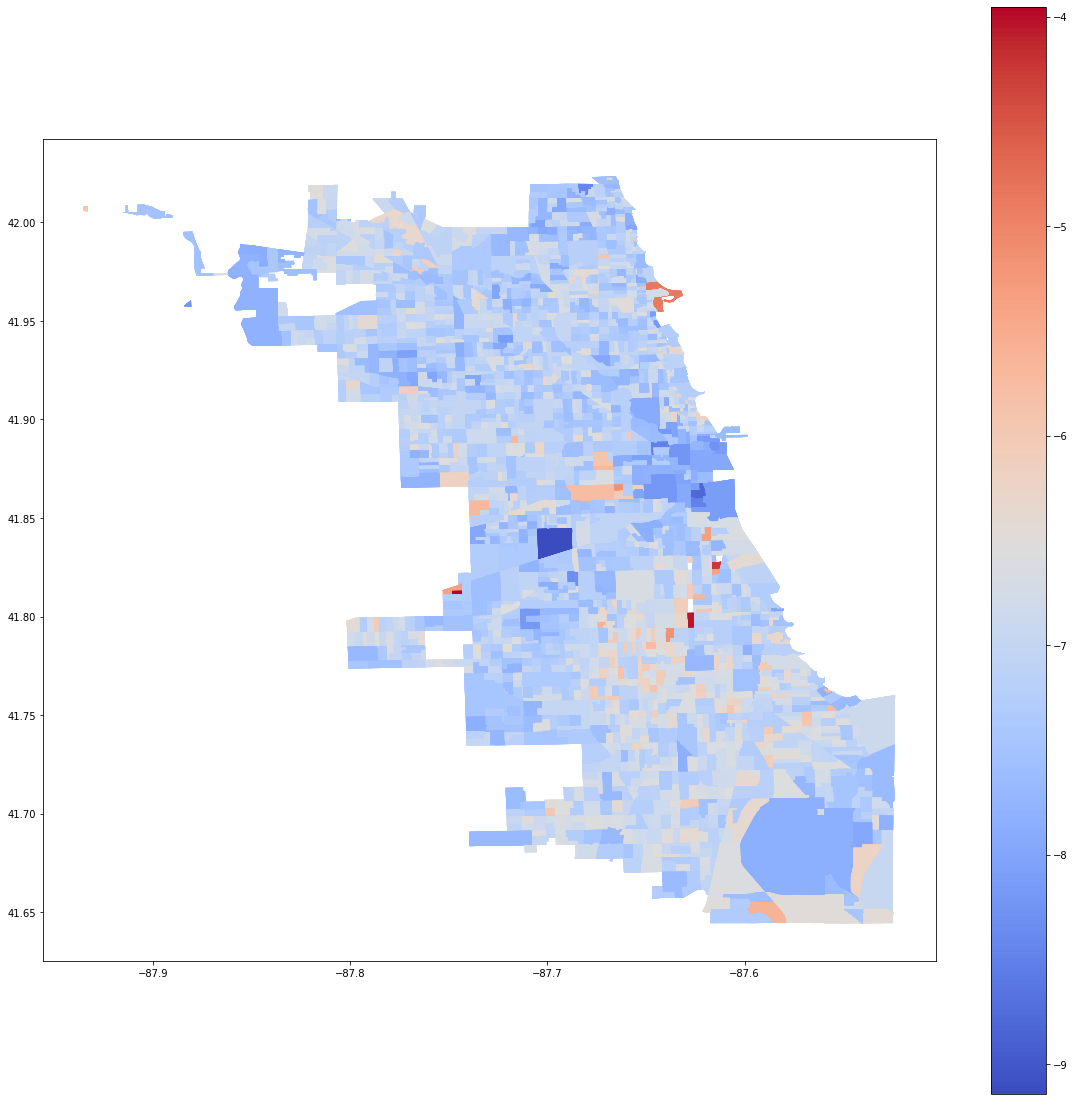

In [22]:
crime_graph2.plot(figsize=(20, 20), column='log_crime_rate', cmap=plt.cm.coolwarm, legend=True)

# Transit

In [23]:
from shapely.ops import nearest_points
from shapely.geometry import Point
import geopy.distance

In [24]:
cta_df = pd.read_csv("data/CTA-LStops.csv")
cta_df.head()
# the two gdfs are: cta_gdf and census_gdf

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [25]:
def clean(df):
    split = df.split(',')
    lst = []
    for i in split:
         lst.append(i.strip('() '))
    return lst

cta_df['location_split'] = cta_df['Location'].apply(lambda x: clean(x))
cta_df['Longitude'] = cta_df['location_split'].map(lambda x: float(x[1]))
cta_df['Latitude'] = cta_df['location_split'].map(lambda x: float(x[0]))

cta_df.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location,location_split,Longitude,Latitude
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)","[41.857908, -87.669147]",-87.669147,41.857908
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)","[41.857908, -87.669147]",-87.669147,41.857908
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)","[41.829353, -87.680622]",-87.680622,41.829353
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)","[41.829353, -87.680622]",-87.680622,41.829353
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)","[41.831677, -87.625826]",-87.625826,41.831677


In [26]:
cta_gdf = gpd.GeoDataFrame(
    cta_df, geometry=gpd.points_from_xy(cta_df.Longitude, cta_df.Latitude))
cta_gdf = cta_gdf[['STOP_ID', 'STOP_NAME', 'STATION_NAME', 'Longitude', 'Latitude', 'geometry']]
cta_gdf

,STOP_ID,STOP_NAME,STATION_NAME,Longitude,Latitude,geometry
0,30162,18th (54th/Cermak-bound),18th,-87.669147,41.857908,POINT (-87.66915 41.85791)
1,30161,18th (Loop-bound),18th,-87.669147,41.857908,POINT (-87.66915 41.85791)
2,30022,35th/Archer (Loop-bound),35th/Archer,-87.680622,41.829353,POINT (-87.68062 41.82935)
3,30023,35th/Archer (Midway-bound),35th/Archer,-87.680622,41.829353,POINT (-87.68062 41.82935)
4,30214,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,-87.625826,41.831677,POINT (-87.62583 41.83168)
...,...,...,...,...,...,...
295,30106,Wilson (95th-bound),Wilson,-87.657588,41.964273,POINT (-87.65759 41.96427)
296,30383,Washington/Wabash (Outer Loop),Washington/Wabash,-87.626189,41.883220,POINT (-87.62619 41.88322)
297,30385,Wilson (Loop-bound),Wilson,-87.657588,41.964273,POINT (-87.65759 41.96427)
298,30033,Ashland (Harlem-54th/Cermak-bound),Ashland,-87.666969,41.885269,POINT (-87.66697 41.88527)


In [27]:
#census_gdf2 = allmerged_gdf2.sample(10)
#census_gdf2
census_gdf2 = allmerged_gdf.dropna()
census_gdf2 = census_gdf2.drop_duplicates('GEO_ID')
census_gdf2.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year_left', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'geometry', 'index_right', 'total_pop', 'GEO_ID',
       'Year_right', 'geo_12', 'statefp10', 'name10', 'blockce10',
       'tract_bloc', 'geoid10', 'tractce10', 'countyfp10'],
      dtype='object')

In [28]:
census_gdf2 = census_gdf2[['GEO_ID', 'Latitude', 'Longitude', 'geometry']]
census_gdf2

,GEO_ID,Latitude,Longitude,geometry
3,1500000US170318418001,41.761413,-87.598159,POINT (-87.59816 41.76141)
5,1500000US170312518001,41.881713,-87.753368,POINT (-87.75337 41.88171)
8,1500000US170316604003,41.780705,-87.709365,POINT (-87.70937 41.78070)
10,1500000US170315102002,41.716443,-87.563440,POINT (-87.56344 41.71644)
14,1500000US170316718001,41.760483,-87.655729,POINT (-87.65573 41.76048)
...,...,...,...,...
107048,1500000US170317707002,41.980739,-87.878798,POINT (-87.87880 41.98074)
148481,1500000US170318233041,41.691678,-87.691670,POINT (-87.69167 41.69168)
542275,1500000US170317708002,41.957636,-87.884013,POINT (-87.88401 41.95764)
773918,1500000US170318081002,42.001454,-87.806750,POINT (-87.80675 42.00145)


In [29]:
# source: https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
# nearest point in gpd2 (cta_gdf) for each row in gpd1 (census_gdf)

# unary union of CTA 
pts3 = cta_gdf.geometry.unary_union
def near(point, pts=pts3):
    # find the nearest point and return the corresponding Place value
    nearest = cta_gdf.geometry == nearest_points(point, pts)[1]
    return max(cta_gdf[nearest].STOP_ID)
  
    
census_gdf2['STOP_ID'] = census_gdf2.apply(lambda row: near(row.geometry), axis=1)
census_gdf2

,GEO_ID,Latitude,Longitude,geometry,STOP_ID
3,1500000US170318418001,41.761413,-87.598159,POINT (-87.59816 41.76141),30140
5,1500000US170312518001,41.881713,-87.753368,POINT (-87.75337 41.88171),30136
8,1500000US170316604003,41.780705,-87.709365,POINT (-87.70937 41.78070),30220
10,1500000US170315102002,41.716443,-87.563440,POINT (-87.56344 41.71644),30089
14,1500000US170316718001,41.760483,-87.655729,POINT (-87.65573 41.76048),30057
...,...,...,...,...,...
107048,1500000US170317707002,41.980739,-87.878798,POINT (-87.87880 41.98074),30160
148481,1500000US170318233041,41.691678,-87.691670,POINT (-87.69167 41.69168),30089
542275,1500000US170317708002,41.957636,-87.884013,POINT (-87.88401 41.95764),30172
773918,1500000US170318081002,42.001454,-87.806750,POINT (-87.80675 42.00145),30146


In [30]:
merged_with_cta = census_gdf2.merge(cta_gdf, on="STOP_ID", how="left")
merged_with_cta

,GEO_ID,Latitude_x,Longitude_x,geometry_x,STOP_ID,STOP_NAME,STATION_NAME,Longitude_y,Latitude_y,geometry_y
0,1500000US170318418001,41.761413,-87.598159,POINT (-87.59816 41.76141),30140,Cottage Grove (Harlem-bound),Cottage Grove,-87.605857,41.780309,POINT (-87.60586 41.78031)
1,1500000US170312518001,41.881713,-87.753368,POINT (-87.75337 41.88171),30136,Laramie (Harlem-bound),Laramie,-87.754986,41.887163,POINT (-87.75499 41.88716)
2,1500000US170316604003,41.780705,-87.709365,POINT (-87.70937 41.78070),30220,Kedzie (Midway-bound),Kedzie,-87.704406,41.804236,POINT (-87.70441 41.80424)
3,1500000US170315102002,41.716443,-87.563440,POINT (-87.56344 41.71644),30089,95th/Dan Ryan (95th-bound),95th/Dan Ryan,-87.624342,41.722377,POINT (-87.62434 41.72238)
4,1500000US170316718001,41.760483,-87.655729,POINT (-87.65573 41.76048),30057,Ashland/63rd (Terminal arrival),Ashland/63rd,-87.663766,41.778860,POINT (-87.66377 41.77886)
...,...,...,...,...,...,...,...,...,...,...
2182,1500000US170317707002,41.980739,-87.878798,POINT (-87.87880 41.98074),30160,Rosemont (Forest Pk-bound),Rosemont,-87.859388,41.983507,POINT (-87.85939 41.98351)
2183,1500000US170318233041,41.691678,-87.691670,POINT (-87.69167 41.69168),30089,95th/Dan Ryan (95th-bound),95th/Dan Ryan,-87.624342,41.722377,POINT (-87.62434 41.72238)
2184,1500000US170317708002,41.957636,-87.884013,POINT (-87.88401 41.95764),30172,O'Hare (Forest Pk-bound),O'Hare,-87.904223,41.977665,POINT (-87.90422 41.97767)
2185,1500000US170318081002,42.001454,-87.806750,POINT (-87.80675 42.00145),30146,Harlem (O'Hare Branch) (Forest Pk-bound),Harlem,-87.808900,41.982270,POINT (-87.80890 41.98227)


In [31]:
def calc_distance(coords_1, coords_2):
    return geopy.distance.distance(coords_1, coords_2).miles

merged_with_cta['distance'] = merged_with_cta.apply(lambda row: calc_distance((row.Longitude_x, row.Latitude_x), (row.Longitude_y, row.Latitude_y)), axis=1)
merged_with_cta

,GEO_ID,Latitude_x,Longitude_x,geometry_x,STOP_ID,STOP_NAME,STATION_NAME,Longitude_y,Latitude_y,geometry_y,distance
0,1500000US170318418001,41.761413,-87.598159,POINT (-87.59816 41.76141),30140,Cottage Grove (Harlem-bound),Cottage Grove,-87.605857,41.780309,POINT (-87.60586 41.78031),0.537042
1,1500000US170312518001,41.881713,-87.753368,POINT (-87.75337 41.88171),30136,Laramie (Harlem-bound),Laramie,-87.754986,41.887163,POINT (-87.75499 41.88716),0.113297
2,1500000US170316604003,41.780705,-87.709365,POINT (-87.70937 41.78070),30220,Kedzie (Midway-bound),Kedzie,-87.704406,41.804236,POINT (-87.70441 41.80424),0.350314
3,1500000US170315102002,41.716443,-87.563440,POINT (-87.56344 41.71644),30089,95th/Dan Ryan (95th-bound),95th/Dan Ryan,-87.624342,41.722377,POINT (-87.62434 41.72238),4.226759
4,1500000US170316718001,41.760483,-87.655729,POINT (-87.65573 41.76048),30057,Ashland/63rd (Terminal arrival),Ashland/63rd,-87.663766,41.778860,POINT (-87.66377 41.77886),0.560197
...,...,...,...,...,...,...,...,...,...,...,...
2182,1500000US170317707002,41.980739,-87.878798,POINT (-87.87880 41.98074),30160,Rosemont (Forest Pk-bound),Rosemont,-87.859388,41.983507,POINT (-87.85939 41.98351),1.347092
2183,1500000US170318233041,41.691678,-87.691670,POINT (-87.69167 41.69168),30089,95th/Dan Ryan (95th-bound),95th/Dan Ryan,-87.624342,41.722377,POINT (-87.62434 41.72238),4.673552
2184,1500000US170317708002,41.957636,-87.884013,POINT (-87.88401 41.95764),30172,O'Hare (Forest Pk-bound),O'Hare,-87.904223,41.977665,POINT (-87.90422 41.97767),1.403533
2185,1500000US170318081002,42.001454,-87.806750,POINT (-87.80675 42.00145),30146,Harlem (O'Hare Branch) (Forest Pk-bound),Harlem,-87.808900,41.982270,POINT (-87.80890 41.98227),0.157663


In [33]:
merged_with_cta = gpd.GeoDataFrame(merged_with_cta)
merged_with_cta = merged_with_cta.rename(columns={"geometry_x": "geometry"})

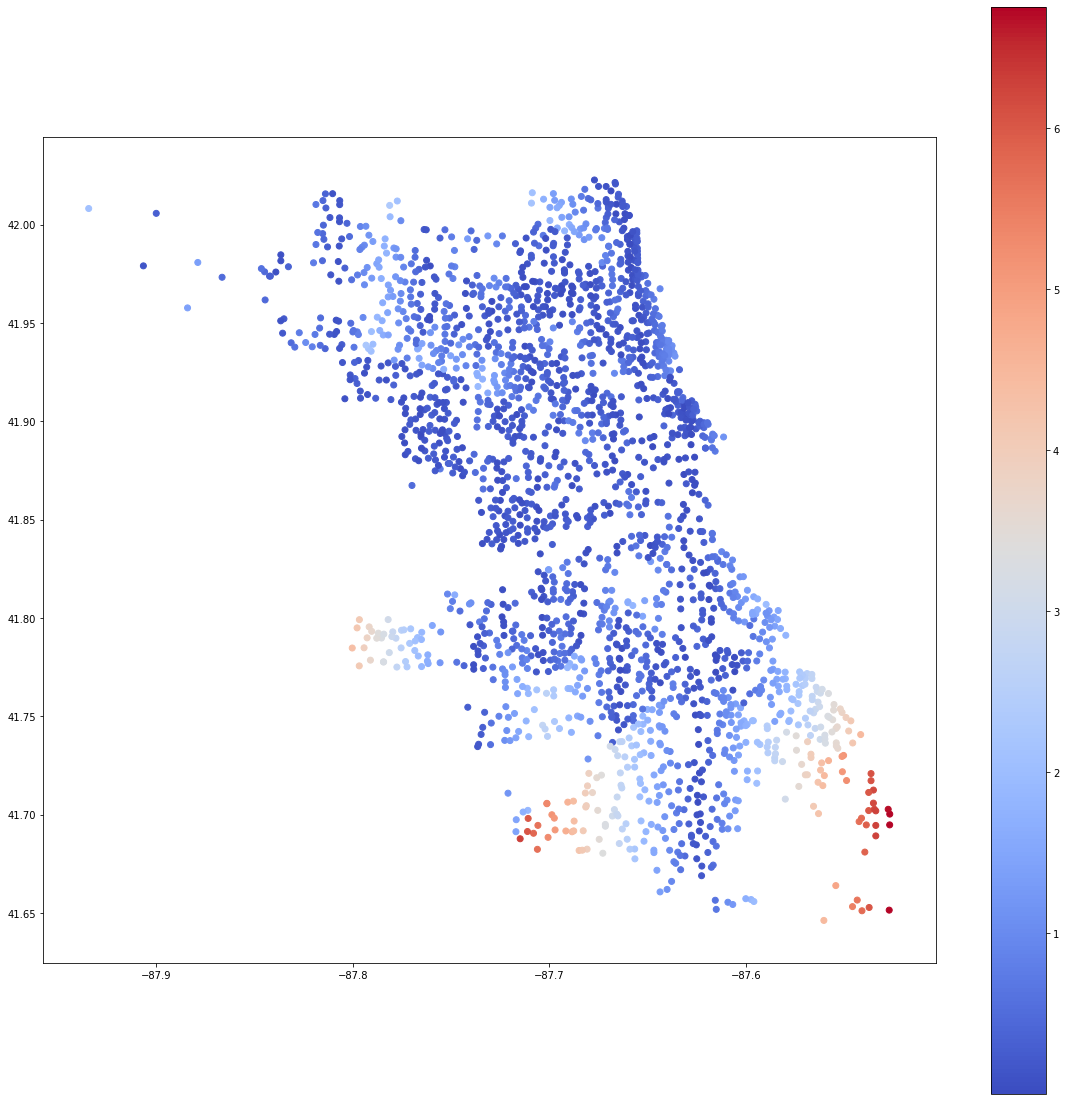

In [34]:
merged_with_cta.plot(figsize=(20, 20), column='distance', cmap=plt.cm.coolwarm, legend=True)

## Saving datasets to csv

In [35]:
# from crimes: final_gdf ... from CTA: merged_with_cta
final_crimes = final_gdf
final_gdf.to_csv('crimes.csv')

In [36]:
final_cta = merged_with_cta[['GEO_ID','STOP_ID','STATION_NAME', 'distance']]
final_cta.to_csv('cta_dist.csv')